In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!pip install keras-layer-normalization

  Created wheel for keras-layer-normalization: filename=keras_layer_normalization-0.16.0-py3-none-any.whl size=4668 sha256=1c9f70ce1690ed95be864b9b20c2031c16ae7d2e234cd87c663092ba000874bd
  Stored in directory: /root/.cache/pip/wheels/85/5d/1c/2e619f594f69fbcf8bc20943b27d414871c409be053994813e
Successfully built keras-layer-normalization


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import preprocessing

import tensorflow as tf
from keras.layers import Input, Dense, Lambda, Layer, Activation
from tensorflow.keras.layers import BatchNormalization
#from keras.layers.normalization import BatchNormalization
from keras.models import Model
from keras import backend as K
from keras import metrics, optimizers
from keras.callbacks import Callback
import keras


%matplotlib inline

np.random.seed(123)

In [3]:
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.svm import LinearSVC
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import multilabel_confusion_matrix, ConfusionMatrixDisplay


here, we use a VAE which is designed by Gregory Way and Casey Greene in 2017 and published in  https://github.com/greenelab/tybalt in their paper titled "A Variational Autoencoder trained on Pan-Cancer Gene Expression" .


LOAD DATA

In [8]:
import pathlib

rna_df = pd.read_table(pathlib.Path.cwd().joinpath('..\data\pancan_scaled_zeroone_rnaseq.tsv'), index_col=0)

test_set_percent = 0.1
rna_test_df = rna_df.sample(frac=test_set_percent,random_state=42)
rna_train_df = rna_df.drop(rna_test_df.index)

rna_df.shape

(10459, 5000)

In [9]:
rna_df

,RPS4Y1,XIST,KRT5,AGR2,CEACAM5,KRT6A,KRT14,CEACAM6,DDX3Y,KDM5D,...,FAM129A,C8orf48,CDK5R1,FAM81A,C13orf18,GDPD3,SMAGP,C2orf85,POU5F1B,CHST2
TCGA-02-0047-01,0.678296,0.289910,0.034230,0.000000,0.000000,0.084731,0.031863,0.037709,0.746797,0.687833,...,0.440610,0.428782,0.732819,0.634340,0.580662,0.294313,0.458134,0.478219,0.168263,0.638497
TCGA-02-0055-01,0.200633,0.654917,0.181993,0.000000,0.000000,0.100606,0.050011,0.092586,0.103725,0.140642,...,0.620658,0.363207,0.592269,0.602755,0.610192,0.374569,0.722420,0.271356,0.160465,0.602560
TCGA-02-2483-01,0.785980,0.140842,0.081082,0.000000,0.000000,0.000000,0.000000,0.000000,0.730648,0.657189,...,0.437658,0.471489,0.868774,0.471141,0.487212,0.385521,0.466642,0.784059,0.160797,0.557074
TCGA-02-2485-01,0.720258,0.122554,0.180042,0.000000,0.000000,0.000000,0.000000,0.000000,0.720306,0.719855,...,0.553306,0.373344,0.818608,0.691962,0.635023,0.430647,0.453690,0.364494,0.161363,0.607895
TCGA-02-2486-01,0.767127,0.210393,0.034017,0.000000,0.061161,0.000000,0.053021,0.000000,0.739546,0.665684,...,0.601268,0.379943,0.506839,0.684320,0.607821,0.320113,0.476190,0.122722,0.389544,0.698548
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA-ZS-A9CG-01,0.759329,0.000000,0.000000,0.000000,0.040051,0.035649,0.000000,0.000000,0.742643,0.675310,...,0.264960,0.121053,0.397881,0.141263,0.198601,0.225373,0.491042,0.000000,0.330955,0.331286
TCGA-ZT-A8OM-01,0.061373,0.503775,0.697684,0.358729,0.158522,0.216036,0.402744,0.381339,0.000000,0.000000,...,0.303270,0.192819,0.276325,0.618329,0.665054,0.565321,0.599794,0.651202,0.417741,0.533694
TCGA-ZU-A8S4-01,0.659884,0.373266,0.078353,0.520010,0.322909,0.141821,0.199049,0.633337,0.624240,0.611360,...,0.552219,0.513310,0.558477,0.462850,0.441541,0.301877,0.827853,0.323106,0.232801,0.536586
TCGA-ZU-A8S4-11,0.724253,0.152220,0.318005,0.156949,0.088556,0.325932,0.000000,0.169384,0.783505,0.696429,...,0.307095,0.301762,0.421057,0.092966,0.321146,0.080400,0.470893,0.086766,0.278904,0.341701


# Hyper Parameters

[Way et al.](https://www.worldscientific.com/doi/pdf/10.1142/9789813235533_0008)  explored the efficacy of a technique called Warm-up. [Warm-up has been shown to be beneficial](https://arxiv.org/pdf/1602.02282.pdf) for auto-encoders in certain applications.



In [10]:
original_dim = rna_df.shape[1]
latent_dim = 100

batch_size = 50
epochs = 50
learning_rate = 0.0005
epsilon_std = 1.0

# Setting beta to 1 results in a full VAE.
beta = K.variable(1)
kappa = 0.02

Sampling  by considering Beta and Kappa in warmupcallback

In [11]:
def sampling(args):
    """Samples from a normal distribution."""
    z_mean, z_log_var = args
    epsilon = K.random_normal(
        shape=tf.shape(z_mean),
        mean=0.,
        stddev=epsilon_std
    )
    return z_mean + K.exp(z_log_var / 2) * epsilon


class WarmUpCallback(Callback):
    """Warm-up implementation as seen in Sonderby et al."""
    def __init__(self, beta, kappa):
        self.beta = beta
        self.kappa = kappa

    def on_epoch_end(self, epoch, logs={}):
        if K.get_value(self.beta) < 1:
            K.set_value(self.beta, K.get_value(self.beta) + self.kappa)

## Model

In [12]:
x_input = Input(shape=(original_dim,))

z_mean = Dense(latent_dim, kernel_initializer='glorot_uniform')(x_input)
z_mean = BatchNormalization()(z_mean)
z_mean = Activation('relu')(z_mean)

z_log_var = Dense(latent_dim, kernel_initializer='glorot_uniform')(x_input)
z_log_var = BatchNormalization()(z_log_var)
z_log_var = Activation('relu')(z_log_var)

z = Lambda(sampling, output_shape=(latent_dim, ))([z_mean, z_log_var])

x_recon = Dense(
    original_dim,
    kernel_initializer='glorot_uniform',
    activation='sigmoid'
)(z)


vae = Model(x_input, x_recon)

## Loss

In [13]:
recon_loss = original_dim * metrics.binary_crossentropy(x_input, x_recon)
kl_loss = - 0.5 * K.sum(
    1 + z_log_var - K.square(z_mean) - K.exp(z_log_var),
    axis=-1
)
vae_loss = K.mean(recon_loss + (K.get_value(beta) * kl_loss))
vae.add_loss(vae_loss)

adam =tf.keras.optimizers.Adam(lr=learning_rate)
vae.compile(optimizer=adam, loss=None)

C:\Users\edudi\miniconda3\envs\project_env\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


## Compile and Training


In [14]:


hist = vae.fit(
    np.array(rna_train_df),
    shuffle=True,
    epochs=epochs,
    verbose=1,
    batch_size=batch_size,
    validation_data=(np.array(rna_test_df), None),
    callbacks=[WarmUpCallback(beta, kappa)]
)

Epoch 1/50
189/189 [==============================] - 6s 24ms/step - loss: 3041.2957 - val_loss: 2954.0818
Epoch 2/50
189/189 [==============================] - 4s 21ms/step - loss: 2875.6372 - val_loss: 2862.7769
Epoch 3/50
189/189 [==============================] - 4s 22ms/step - loss: 2845.0850 - val_loss: 2844.0667
Epoch 4/50
189/189 [==============================] - 4s 20ms/step - loss: 2831.7788 - val_loss: 2831.5320
Epoch 5/50
189/189 [==============================] - 4s 20ms/step - loss: 2825.7820 - val_loss: 2825.6377
Epoch 6/50
189/189 [==============================] - 4s 23ms/step - loss: 2822.9646 - val_loss: 2827.8269
Epoch 7/50
189/189 [==============================] - 7s 35ms/step - loss: 2820.0317 - val_loss: 2825.7920
Epoch 8/50
189/189 [==============================] - 6s 30ms/step - loss: 2819.1499 - val_loss: 2824.4033
Epoch 9/50
189/189 [==============================] - 5s 28ms/step - loss: 2817.6538 - val_loss: 2815.7566
Epoch 10/50
189/189 [================

## Training Performance

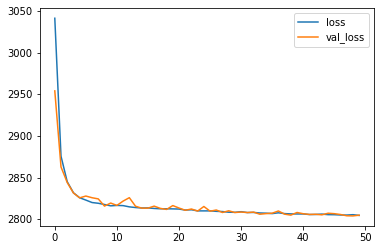

In [15]:
history_df = pd.DataFrame(hist.history)
history_df.plot()
plt.show()

In [17]:
vae.save_weights(filepath=pathlib.Path.cwd().joinpath("../data/vae_weights.h5"))

In [18]:
vae.save(filepath=pathlib.Path.cwd().joinpath("../data/vae.h5"))

## Encoder

Now that the model is trained, we construct the encoder and embed our Gibbs energy networks in the lower dimensional space.

In [19]:
encoder = Model(x_input, z_mean)

# Note: if you skipped the model training, you can load the already trained encoder with:
# encoder = keras.models.load_model('data/encoder.h5')

encoded_rna_df = encoder.predict_on_batch(rna_df)
encoded_rna_df = pd.DataFrame(encoded_rna_df, index=rna_df.index)

In [20]:
encoded_rna_df

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
TCGA-02-0047-01,1.952373,0.000000,0.000000,0.158568,0.000000,0.948159,0.000000,3.521688,0.000000,0.0,...,0.000000,0.000000,0.000000,0.00000,1.989137,0.000000,0.000000,0.000000,0.000000,0.000000
TCGA-02-0055-01,2.203492,0.000000,0.000000,1.080273,0.000000,0.804240,0.735549,1.741585,0.000000,0.0,...,1.115288,0.000000,0.000000,0.00000,0.647186,0.000000,0.000000,0.172660,0.000000,0.000000
TCGA-02-2483-01,2.307677,0.000000,0.000000,0.985109,0.000000,0.000000,0.000000,2.797002,0.000000,0.0,...,0.490245,0.000000,1.150786,0.00000,2.437016,0.000000,0.000000,0.000000,0.000000,0.000000
TCGA-02-2485-01,3.340275,0.000000,0.000000,0.030936,0.000000,1.310904,0.000000,3.531389,0.000000,0.0,...,0.032520,0.000000,0.000000,0.00000,2.231414,0.000000,0.000000,0.000000,0.000000,0.000000
TCGA-02-2486-01,3.592416,0.000000,0.000000,0.741552,0.000000,4.371950,0.065276,3.023221,0.000000,0.0,...,0.003596,0.000000,0.000000,0.00000,2.253482,0.701364,0.000000,0.102356,0.388987,1.149576
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA-ZS-A9CG-01,0.069515,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.069550,0.0,...,3.000244,3.455859,1.412889,0.00000,4.077814,0.000000,0.000000,1.062856,0.000000,0.000000
TCGA-ZT-A8OM-01,0.000000,0.000000,0.000000,0.000000,1.033517,0.884767,0.000000,3.063824,0.000000,0.0,...,3.148020,0.000000,3.121447,0.35465,0.000000,0.000000,0.000000,0.000000,0.606596,1.036450
TCGA-ZU-A8S4-01,0.218180,0.559555,0.604375,1.635787,0.000000,0.871122,0.055044,0.059979,0.449381,0.0,...,0.050048,0.000000,0.000000,0.00000,0.677693,0.434970,0.394845,0.000000,0.000000,1.620996
TCGA-ZU-A8S4-11,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.089807,3.224851,0.0,...,1.778762,1.776836,0.000000,0.00000,3.381880,0.000000,0.000000,3.313728,0.000000,0.000000


In [21]:
encoded_rna_df.index.name='sample_id'

In [22]:
encoded_rna_df

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
sample_id,,,,,,,,,,,,,,,,,,,,,
TCGA-02-0047-01,1.952373,0.000000,0.000000,0.158568,0.000000,0.948159,0.000000,3.521688,0.000000,0.0,...,0.000000,0.000000,0.000000,0.00000,1.989137,0.000000,0.000000,0.000000,0.000000,0.000000
TCGA-02-0055-01,2.203492,0.000000,0.000000,1.080273,0.000000,0.804240,0.735549,1.741585,0.000000,0.0,...,1.115288,0.000000,0.000000,0.00000,0.647186,0.000000,0.000000,0.172660,0.000000,0.000000
TCGA-02-2483-01,2.307677,0.000000,0.000000,0.985109,0.000000,0.000000,0.000000,2.797002,0.000000,0.0,...,0.490245,0.000000,1.150786,0.00000,2.437016,0.000000,0.000000,0.000000,0.000000,0.000000
TCGA-02-2485-01,3.340275,0.000000,0.000000,0.030936,0.000000,1.310904,0.000000,3.531389,0.000000,0.0,...,0.032520,0.000000,0.000000,0.00000,2.231414,0.000000,0.000000,0.000000,0.000000,0.000000
TCGA-02-2486-01,3.592416,0.000000,0.000000,0.741552,0.000000,4.371950,0.065276,3.023221,0.000000,0.0,...,0.003596,0.000000,0.000000,0.00000,2.253482,0.701364,0.000000,0.102356,0.388987,1.149576
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA-ZS-A9CG-01,0.069515,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.069550,0.0,...,3.000244,3.455859,1.412889,0.00000,4.077814,0.000000,0.000000,1.062856,0.000000,0.000000
TCGA-ZT-A8OM-01,0.000000,0.000000,0.000000,0.000000,1.033517,0.884767,0.000000,3.063824,0.000000,0.0,...,3.148020,0.000000,3.121447,0.35465,0.000000,0.000000,0.000000,0.000000,0.606596,1.036450
TCGA-ZU-A8S4-01,0.218180,0.559555,0.604375,1.635787,0.000000,0.871122,0.055044,0.059979,0.449381,0.0,...,0.050048,0.000000,0.000000,0.00000,0.677693,0.434970,0.394845,0.000000,0.000000,1.620996


In [25]:
encoded_rna_df.to_csv(pathlib.Path.cwd().joinpath("../data/encoded_rna_df.csv"))

In [26]:
encoder.save_weights(pathlib.Path.cwd().joinpath("../data/encoder_weights.h5"))

In [27]:
encoder.load_weights(pathlib.Path.cwd().joinpath("../data/encoder_weights.h5"))

***************Decoder *****

In [28]:
from keras.models import Model, Sequential

In [29]:
decoder_model = Sequential()
decoder_model.add(Dense(original_dim, activation='sigmoid',
                                     input_dim=latent_dim))
rna_reconstruct = decoder_model(z)

In [30]:
decoder_model.save_weights(pathlib.Path.cwd().joinpath("../data/decoder_weights.h5"))

Classification 
MLP and SVM classifier to see their performance on the new features extracted from vae

In [31]:
clinical_df=pd.read_csv(pathlib.Path.cwd().joinpath("../data/clinical_data.csv"))

In [32]:
clinical_df

,sample_id,days_to_death,platform,analysis_center,gender,race,ethnicity,organ,acronym,disease,vital_status,sample_type,age_at_diagnosis,percent_tumor_nuclei,drug,year_of_diagnosis,stage
0,TCGA-CD-8534-01,NaN,Illumina HiSeq,BCGSC,male,asian,not hispanic or latino,Stomach,STAD,Stomach adenocarcinoma,alive,Primary Tumor,41.0,85.0,NaN,2011,Stage II
1,TCGA-ER-A19A-06,NaN,Illumina HiSeq,UNC,male,white,not hispanic or latino,Skin,SKCM,Skin Cutaneous Melanoma,alive,Metastatic,79.0,85.0,NaN,2006,Stage IV
2,TCGA-C5-A1M8-01,NaN,Illumina HiSeq,UNC,female,white,not hispanic or latino,Cervix,CESC,Cervical squamous cell carcinoma and endocervi...,alive,Primary Tumor,43.0,85.0,NaN,2001,NaN
3,TCGA-D1-A0ZN-01,NaN,Illumina GA,UNC,female,white,not hispanic or latino,Uterus,UCEC,Uterine Corpus Endometrial Carcinoma,alive,Primary Tumor,60.0,60.0,NaN,2009,NaN
4,TCGA-EM-A4FF-01,NaN,Illumina HiSeq,UNC,female,not reported,not reported,Thyroid,THCA,Thyroid carcinoma,alive,Primary Tumor,40.0,75.0,NaN,2006,Stage I
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11279,TCGA-60-2724-01,NaN,Illumina HiSeq,UNC,male,white,not hispanic or latino,Lung,LUSC,Lung squamous cell carcinoma,alive,Primary Tumor,47.0,85.0,Navelbine,2008.0,Stage IIIA
11280,TCGA-HE-A5NK-01,NaN,Illumina HiSeq,UNC,male,not reported,not reported,Kidney,KIRP,Kidney renal papillary cell carcinoma,alive,Primary Tumor,82.0,80.0,NaN,NaN,NaN
11281,TCGA-ZF-A9RC-01,NaN,Illumina HiSeq,UNC,male,white,not hispanic or latino,Bladder,BLCA,Bladder Urothelial Carcinoma,alive,Primary Tumor,77.0,60.0,NaN,2007.0,Stage III
11282,TCGA-E9-A1R7-11,NaN,Illumina HiSeq,UNC,female,white,not hispanic or latino,Breast,BRCA,Breast invasive carcinoma,alive,Solid Tissue Normal,64.0,0.0,Tamoxifen,2011.0,Stage IIA


In [33]:
sub_clinical=clinical_df[['sample_id','disease']]

In [34]:
sub_clinical

,sample_id,disease
0,TCGA-CD-8534-01,Stomach adenocarcinoma
1,TCGA-ER-A19A-06,Skin Cutaneous Melanoma
2,TCGA-C5-A1M8-01,Cervical squamous cell carcinoma and endocervi...
3,TCGA-D1-A0ZN-01,Uterine Corpus Endometrial Carcinoma
4,TCGA-EM-A4FF-01,Thyroid carcinoma
...,...,...
11279,TCGA-60-2724-01,Lung squamous cell carcinoma
11280,TCGA-HE-A5NK-01,Kidney renal papillary cell carcinoma
11281,TCGA-ZF-A9RC-01,Bladder Urothelial Carcinoma
11282,TCGA-E9-A1R7-11,Breast invasive carcinoma


In [35]:
data_set=encoded_rna_df.join(sub_clinical.set_index('sample_id'), on='sample_id')

In [36]:
data_set

,0,1,2,3,4,5,6,7,8,9,...,91,92,93,94,95,96,97,98,99,disease
sample_id,,,,,,,,,,,,,,,,,,,,,
TCGA-02-0047-01,1.952373,0.000000,0.000000,0.158568,0.000000,0.948159,0.000000,3.521688,0.000000,0.0,...,0.000000,0.000000,0.00000,1.989137,0.000000,0.000000,0.000000,0.000000,0.000000,Glioblastoma multiforme
TCGA-02-0055-01,2.203492,0.000000,0.000000,1.080273,0.000000,0.804240,0.735549,1.741585,0.000000,0.0,...,0.000000,0.000000,0.00000,0.647186,0.000000,0.000000,0.172660,0.000000,0.000000,Glioblastoma multiforme
TCGA-02-2483-01,2.307677,0.000000,0.000000,0.985109,0.000000,0.000000,0.000000,2.797002,0.000000,0.0,...,0.000000,1.150786,0.00000,2.437016,0.000000,0.000000,0.000000,0.000000,0.000000,Glioblastoma multiforme
TCGA-02-2485-01,3.340275,0.000000,0.000000,0.030936,0.000000,1.310904,0.000000,3.531389,0.000000,0.0,...,0.000000,0.000000,0.00000,2.231414,0.000000,0.000000,0.000000,0.000000,0.000000,Glioblastoma multiforme
TCGA-02-2486-01,3.592416,0.000000,0.000000,0.741552,0.000000,4.371950,0.065276,3.023221,0.000000,0.0,...,0.000000,0.000000,0.00000,2.253482,0.701364,0.000000,0.102356,0.388987,1.149576,Glioblastoma multiforme
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA-ZS-A9CG-01,0.069515,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.069550,0.0,...,3.455859,1.412889,0.00000,4.077814,0.000000,0.000000,1.062856,0.000000,0.000000,Liver hepatocellular carcinoma
TCGA-ZT-A8OM-01,0.000000,0.000000,0.000000,0.000000,1.033517,0.884767,0.000000,3.063824,0.000000,0.0,...,0.000000,3.121447,0.35465,0.000000,0.000000,0.000000,0.000000,0.606596,1.036450,Thymoma
TCGA-ZU-A8S4-01,0.218180,0.559555,0.604375,1.635787,0.000000,0.871122,0.055044,0.059979,0.449381,0.0,...,0.000000,0.000000,0.00000,0.677693,0.434970,0.394845,0.000000,0.000000,1.620996,Cholangiocarcinoma


In [ ]:

#data_set=data_set.drop(['sample_id'], axis=1)



In [37]:
data_set=data_set.dropna(subset=['disease'])


In [38]:
data_set

,0,1,2,3,4,5,6,7,8,9,...,91,92,93,94,95,96,97,98,99,disease
sample_id,,,,,,,,,,,,,,,,,,,,,
TCGA-02-0047-01,1.952373,0.000000,0.000000,0.158568,0.000000,0.948159,0.000000,3.521688,0.000000,0.0,...,0.000000,0.000000,0.00000,1.989137,0.000000,0.000000,0.000000,0.000000,0.000000,Glioblastoma multiforme
TCGA-02-0055-01,2.203492,0.000000,0.000000,1.080273,0.000000,0.804240,0.735549,1.741585,0.000000,0.0,...,0.000000,0.000000,0.00000,0.647186,0.000000,0.000000,0.172660,0.000000,0.000000,Glioblastoma multiforme
TCGA-02-2483-01,2.307677,0.000000,0.000000,0.985109,0.000000,0.000000,0.000000,2.797002,0.000000,0.0,...,0.000000,1.150786,0.00000,2.437016,0.000000,0.000000,0.000000,0.000000,0.000000,Glioblastoma multiforme
TCGA-02-2485-01,3.340275,0.000000,0.000000,0.030936,0.000000,1.310904,0.000000,3.531389,0.000000,0.0,...,0.000000,0.000000,0.00000,2.231414,0.000000,0.000000,0.000000,0.000000,0.000000,Glioblastoma multiforme
TCGA-02-2486-01,3.592416,0.000000,0.000000,0.741552,0.000000,4.371950,0.065276,3.023221,0.000000,0.0,...,0.000000,0.000000,0.00000,2.253482,0.701364,0.000000,0.102356,0.388987,1.149576,Glioblastoma multiforme
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA-ZS-A9CG-01,0.069515,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.069550,0.0,...,3.455859,1.412889,0.00000,4.077814,0.000000,0.000000,1.062856,0.000000,0.000000,Liver hepatocellular carcinoma
TCGA-ZT-A8OM-01,0.000000,0.000000,0.000000,0.000000,1.033517,0.884767,0.000000,3.063824,0.000000,0.0,...,0.000000,3.121447,0.35465,0.000000,0.000000,0.000000,0.000000,0.606596,1.036450,Thymoma
TCGA-ZU-A8S4-01,0.218180,0.559555,0.604375,1.635787,0.000000,0.871122,0.055044,0.059979,0.449381,0.0,...,0.000000,0.000000,0.00000,0.677693,0.434970,0.394845,0.000000,0.000000,1.620996,Cholangiocarcinoma


In [39]:
data_set.disease.unique()

array(['Glioblastoma multiforme', 'Ovarian serous cystadenocarcinoma',
       'Lung adenocarcinoma', 'Lung squamous cell carcinoma',
       'Prostate adenocarcinoma', 'Uterine Corpus Endometrial Carcinoma',
       'Bladder Urothelial Carcinoma', 'Testicular Germ Cell Tumors',
       'Esophageal carcinoma ', 'Pancreatic adenocarcinoma',
       'Kidney renal papillary cell carcinoma',
       'Liver hepatocellular carcinoma',
       'Cervical squamous cell carcinoma and endocervical adenocarcinoma',
       'Sarcoma', 'Breast invasive carcinoma', 'Thymoma', 'Mesothelioma',
       'Colon adenocarcinoma', 'Stomach adenocarcinoma',
       'Skin Cutaneous Melanoma', 'Cholangiocarcinoma',
       'Kidney renal clear cell carcinoma', 'Thyroid carcinoma',
       'Head and Neck squamous cell carcinoma', 'Acute Myeloid Leukemia',
       'Rectum adenocarcinoma', 'Brain Lower Grade Glioma',
       'Lymphoid Neoplasm Diffuse Large B-cell Lymphoma',
       'Kidney Chromophobe', 'Uterine Carcinosarcoma',

In [40]:
data_set.to_csv(pathlib.Path.cwd().joinpath("../data/data_set.csv"))

In [41]:
data_set=pd.read_csv(pathlib.Path.cwd().joinpath("../data/data_set.csv"))

In [42]:
data_set_dummy=data_set

In [43]:

disease=pd.get_dummies(data_set_dummy['disease'],drop_first=False)
data_set_dummy=pd.concat([data_set_dummy,disease],axis=1)

data_set_dummy


,sample_id,0,1,2,3,4,5,6,7,8,...,Rectum adenocarcinoma,Sarcoma,Skin Cutaneous Melanoma,Stomach adenocarcinoma,Testicular Germ Cell Tumors,Thymoma,Thyroid carcinoma,Uterine Carcinosarcoma,Uterine Corpus Endometrial Carcinoma,Uveal Melanoma
0,TCGA-02-0047-01,1.952373,0.000000,0.000000,0.158568,0.000000,0.948159,0.000000,3.521689,0.000000,...,0,0,0,0,0,0,0,0,0,0
1,TCGA-02-0055-01,2.203492,0.000000,0.000000,1.080273,0.000000,0.804240,0.735549,1.741586,0.000000,...,0,0,0,0,0,0,0,0,0,0
2,TCGA-02-2483-01,2.307677,0.000000,0.000000,0.985109,0.000000,0.000000,0.000000,2.797002,0.000000,...,0,0,0,0,0,0,0,0,0,0
3,TCGA-02-2485-01,3.340275,0.000000,0.000000,0.030936,0.000000,1.310904,0.000000,3.531389,0.000000,...,0,0,0,0,0,0,0,0,0,0
4,TCGA-02-2486-01,3.592416,0.000000,0.000000,0.741552,0.000000,4.371950,0.065276,3.023221,0.000000,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10497,TCGA-ZS-A9CG-01,0.069515,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.069550,...,0,0,0,0,0,0,0,0,0,0
10498,TCGA-ZT-A8OM-01,0.000000,0.000000,0.000000,0.000000,1.033518,0.884767,0.000000,3.063824,0.000000,...,0,0,0,0,0,1,0,0,0,0
10499,TCGA-ZU-A8S4-01,0.218180,0.559555,0.604375,1.635787,0.000000,0.871122,0.055044,0.059979,0.449381,...,0,0,0,0,0,0,0,0,0,0
10500,TCGA-ZU-A8S4-11,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.089807,3.224851,...,0,0,0,0,0,0,0,0,0,0


In [44]:

data_set_dummy=data_set_dummy.drop(['disease'], axis=1)



In [45]:
data_set_dummy.shape

(10502, 134)

In [46]:
x=data_set_dummy.iloc[:,1:101]
x

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,1.952373,0.000000,0.000000,0.158568,0.000000,0.948159,0.000000,3.521689,0.000000,0.0,...,0.000000,0.000000,0.000000,0.00000,1.989137,0.000000,0.000000,0.000000,0.000000,0.000000
1,2.203492,0.000000,0.000000,1.080273,0.000000,0.804240,0.735549,1.741586,0.000000,0.0,...,1.115288,0.000000,0.000000,0.00000,0.647186,0.000000,0.000000,0.172660,0.000000,0.000000
2,2.307677,0.000000,0.000000,0.985109,0.000000,0.000000,0.000000,2.797002,0.000000,0.0,...,0.490245,0.000000,1.150786,0.00000,2.437016,0.000000,0.000000,0.000000,0.000000,0.000000
3,3.340275,0.000000,0.000000,0.030936,0.000000,1.310904,0.000000,3.531389,0.000000,0.0,...,0.032520,0.000000,0.000000,0.00000,2.231414,0.000000,0.000000,0.000000,0.000000,0.000000
4,3.592416,0.000000,0.000000,0.741552,0.000000,4.371950,0.065276,3.023221,0.000000,0.0,...,0.003596,0.000000,0.000000,0.00000,2.253482,0.701364,0.000000,0.102356,0.388987,1.149576
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10497,0.069515,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.069550,0.0,...,3.000244,3.455859,1.412889,0.00000,4.077814,0.000000,0.000000,1.062856,0.000000,0.000000
10498,0.000000,0.000000,0.000000,0.000000,1.033518,0.884767,0.000000,3.063824,0.000000,0.0,...,3.148020,0.000000,3.121447,0.35465,0.000000,0.000000,0.000000,0.000000,0.606596,1.036450
10499,0.218180,0.559555,0.604375,1.635787,0.000000,0.871122,0.055044,0.059979,0.449381,0.0,...,0.050048,0.000000,0.000000,0.00000,0.677693,0.434970,0.394845,0.000000,0.000000,1.620996
10500,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.089807,3.224851,0.0,...,1.778762,1.776836,0.000000,0.00000,3.381880,0.000000,0.000000,3.313728,0.000000,0.000000


In [47]:
y=data_set_dummy.iloc[:,101:]
y

,Acute Myeloid Leukemia,Adrenocortical carcinoma,Bladder Urothelial Carcinoma,Brain Lower Grade Glioma,Breast invasive carcinoma,Cervical squamous cell carcinoma and endocervical adenocarcinoma,Cholangiocarcinoma,Colon adenocarcinoma,Esophageal carcinoma,Glioblastoma multiforme,...,Rectum adenocarcinoma,Sarcoma,Skin Cutaneous Melanoma,Stomach adenocarcinoma,Testicular Germ Cell Tumors,Thymoma,Thyroid carcinoma,Uterine Carcinosarcoma,Uterine Corpus Endometrial Carcinoma,Uveal Melanoma
0,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10497,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10498,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
10499,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10500,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [48]:
print(y.columns)

Index(['Acute Myeloid Leukemia', 'Adrenocortical carcinoma',
       'Bladder Urothelial Carcinoma', 'Brain Lower Grade Glioma',
       'Breast invasive carcinoma',
       'Cervical squamous cell carcinoma and endocervical adenocarcinoma',
       'Cholangiocarcinoma', 'Colon adenocarcinoma', 'Esophageal carcinoma ',
       'Glioblastoma multiforme', 'Head and Neck squamous cell carcinoma',
       'Kidney Chromophobe', 'Kidney renal clear cell carcinoma',
       'Kidney renal papillary cell carcinoma',
       'Liver hepatocellular carcinoma', 'Lung adenocarcinoma',
       'Lung squamous cell carcinoma',
       'Lymphoid Neoplasm Diffuse Large B-cell Lymphoma', 'Mesothelioma',
       'Ovarian serous cystadenocarcinoma', 'Pancreatic adenocarcinoma',
       'Pheochromocytoma and Paraganglioma', 'Prostate adenocarcinoma',
       'Rectum adenocarcinoma', 'Sarcoma', 'Skin Cutaneous Melanoma',
       'Stomach adenocarcinoma', 'Testicular Germ Cell Tumors', 'Thymoma',
       'Thyroid carcinoma',

In [49]:
 from sklearn.model_selection import train_test_split

In [50]:
from sklearn import svm
from sklearn.svm import LinearSVC
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import multilabel_confusion_matrix, ConfusionMatrixDisplay


In [51]:
X_train, X_test, y_train, y_test = train_test_split(x,y, test_size=0.33, random_state=42)

In [52]:
 #Create the SVM
svm = LinearSVC(random_state=42)

In [53]:
# Make it an Multilabel classifier
multilabel_classifier = MultiOutputClassifier(svm, n_jobs=-1)

In [54]:
# Fit the data to the Multilabel classifier
multilabel_classifier = multilabel_classifier.fit(X_train, y_train)

In [55]:
# Get predictions for test data
y_test_pred = multilabel_classifier.predict(X_test)


In [56]:
# Generate multiclass confusion matrices
matrices = multilabel_confusion_matrix(y_test, y_test_pred)

In [57]:
matrices

array([[[3424,    0],
        [   0,   42]],

       [[3439,    0],
        [   1,   26]],

       [[3323,    5],
        [  10,  128]],

       [[3263,   16],
        [   6,  181]],

       [[3070,    2],
        [   4,  390]],

       [[3351,   10],
        [  12,   93]],

       [[3450,    5],
        [   5,    6]],

       [[3314,   25],
        [  18,  109]],

       [[3400,   13],
        [  26,   27]],

       [[3387,    8],
        [  19,   52]],

       [[3270,   13],
        [  13,  170]],

       [[3418,   13],
        [  11,   24]],

       [[3241,   20],
        [  21,  184]],

       [[3354,    9],
        [  19,   84]],

       [[3316,    5],
        [   5,  140]],

       [[3254,   15],
        [  10,  187]],

       [[3255,   19],
        [  30,  162]],

       [[3454,    0],
        [   0,   12]],

       [[3437,    0],
        [   1,   28]],

       [[3358,    1],
        [   3,  104]],

       [[3402,    5],
        [   1,   58]],

       [[3402,    0],
        [   

In [58]:
matrices.shape


(33, 2, 2)

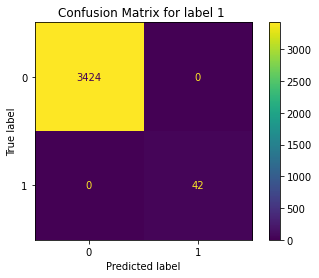

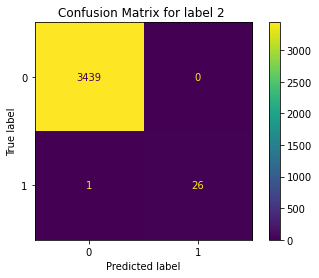

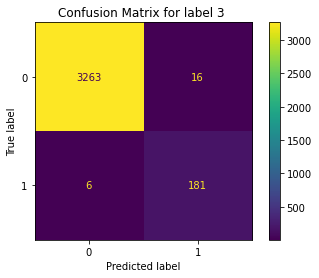

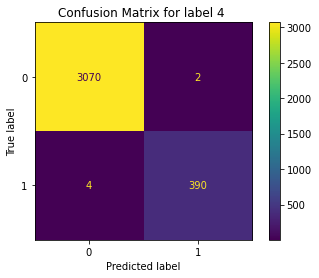

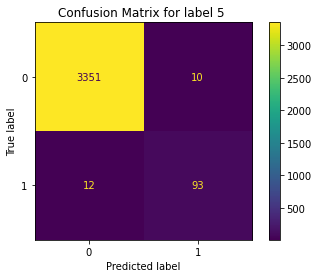

In [59]:

# Plotting matrices: code
cmd = ConfusionMatrixDisplay(matrices[0], display_labels=np.unique(y_test)).plot()
plt.title('Confusion Matrix for label 1 ')
plt.show()
cmd = ConfusionMatrixDisplay(matrices[1], display_labels=np.unique(y_test)).plot()
plt.title('Confusion Matrix for label 2 ')
cmd = ConfusionMatrixDisplay(matrices[3], display_labels=np.unique(y_test)).plot()
plt.title('Confusion Matrix for label 3 ')
plt.show()
cmd = ConfusionMatrixDisplay(matrices[4], display_labels=np.unique(y_test)).plot()
plt.title('Confusion Matrix for label 4 ')
plt.show()
cmd = ConfusionMatrixDisplay(matrices[5], display_labels=np.unique(y_test)).plot()
plt.title('Confusion Matrix for label 5 ')
plt.show()

In [60]:
from sklearn.metrics import f1_score
f1_score(y_test, y_test_pred, average=None)

array([1.        , 0.98113208, 0.94464945, 0.94270833, 0.99236641,
       0.89423077, 0.54545455, 0.83524904, 0.58064516, 0.79389313,
       0.92896175, 0.66666667, 0.8997555 , 0.85714286, 0.96551724,
       0.93734336, 0.86863271, 1.        , 0.98245614, 0.98113208,
       0.95081967, 1.        , 1.        , 0.35294118, 0.88541667,
       0.97643098, 0.86101695, 0.98076923, 0.98823529, 1.        ,
       0.73170732, 0.86178862, 1.        ])

In [61]:
f1_score(y_test, y_test_pred, average='micro')

0.921205098493627

In [62]:
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.svm import LinearSVC
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import multilabel_confusion_matrix, ConfusionMatrixDisplay


In [63]:
X_train, X_test, y_train, y_test = train_test_split(x,y, test_size=0.33, random_state=42)

In [64]:
#Create the SVM
svm = LinearSVC(random_state=42)

In [65]:
# Make it an Multilabel classifier
multilabel_classifier = MultiOutputClassifier(svm, n_jobs=-1)

In [66]:
# Fit the data to the Multilabel classifier
multilabel_classifier = multilabel_classifier.fit(X_train, y_train)

In [67]:
# Get predictions for test data
y_test_pred = multilabel_classifier.predict(X_test)


In [68]:
# Generate multiclass confusion matrices
matrices = multilabel_confusion_matrix(y_test, y_test_pred)
matrices

array([[[3424,    0],
        [   0,   42]],

       [[3439,    0],
        [   1,   26]],

       [[3323,    5],
        [  10,  128]],

       [[3263,   16],
        [   6,  181]],

       [[3070,    2],
        [   4,  390]],

       [[3351,   10],
        [  12,   93]],

       [[3450,    5],
        [   5,    6]],

       [[3314,   25],
        [  18,  109]],

       [[3400,   13],
        [  26,   27]],

       [[3387,    8],
        [  19,   52]],

       [[3270,   13],
        [  13,  170]],

       [[3418,   13],
        [  11,   24]],

       [[3241,   20],
        [  21,  184]],

       [[3354,    9],
        [  19,   84]],

       [[3316,    5],
        [   5,  140]],

       [[3254,   15],
        [  10,  187]],

       [[3255,   19],
        [  30,  162]],

       [[3454,    0],
        [   0,   12]],

       [[3437,    0],
        [   1,   28]],

       [[3358,    1],
        [   3,  104]],

       [[3402,    5],
        [   1,   58]],

       [[3402,    0],
        [   

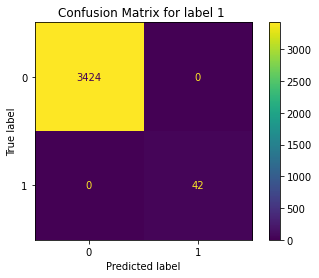

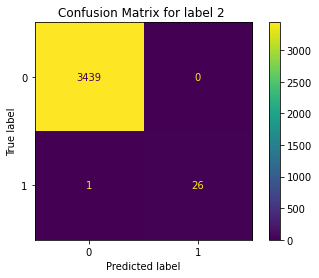

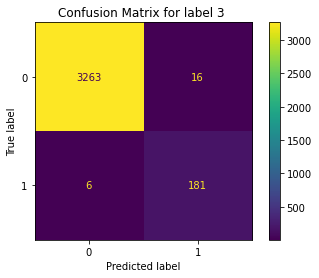

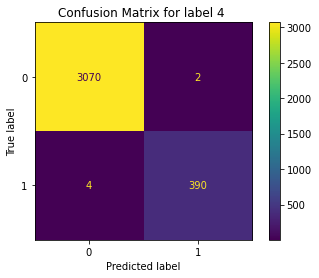

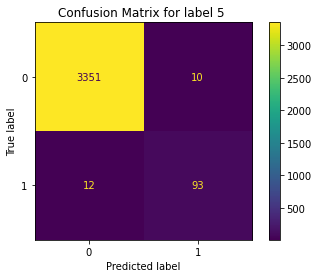

In [69]:
# Plotting matrices: code
cmd = ConfusionMatrixDisplay(matrices[0], display_labels=np.unique(y_test)).plot()
plt.title('Confusion Matrix for label 1 ')
plt.show()
cmd = ConfusionMatrixDisplay(matrices[1], display_labels=np.unique(y_test)).plot()
plt.title('Confusion Matrix for label 2 ')
cmd = ConfusionMatrixDisplay(matrices[3], display_labels=np.unique(y_test)).plot()
plt.title('Confusion Matrix for label 3 ')
plt.show()
cmd = ConfusionMatrixDisplay(matrices[4], display_labels=np.unique(y_test)).plot()
plt.title('Confusion Matrix for label 4 ')
plt.show()
cmd = ConfusionMatrixDisplay(matrices[5], display_labels=np.unique(y_test)).plot()
plt.title('Confusion Matrix for label 5 ')
plt.show()

In [70]:
from sklearn.metrics import f1_score
f1_score(y_test, y_test_pred, average=None)

array([1.        , 0.98113208, 0.94464945, 0.94270833, 0.99236641,
       0.89423077, 0.54545455, 0.83524904, 0.58064516, 0.79389313,
       0.92896175, 0.66666667, 0.8997555 , 0.85714286, 0.96551724,
       0.93734336, 0.86863271, 1.        , 0.98245614, 0.98113208,
       0.95081967, 1.        , 1.        , 0.35294118, 0.88541667,
       0.97643098, 0.86101695, 0.98076923, 0.98823529, 1.        ,
       0.73170732, 0.86178862, 1.        ])

In [71]:
f1_score(y_test, y_test_pred, average='micro')

0.921205098493627

In [72]:
f1_score(y_test, y_test_pred, average='macro')

0.8844564579740055

MLP classifier for 100 extracted features from encoder layer in VAE

In [73]:
from keras.models import Sequential
from keras.layers import Dense
from sklearn.metrics import accuracy_score

In [74]:
 from sklearn.model_selection import train_test_split

In [75]:
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import multilabel_confusion_matrix, ConfusionMatrixDisplay
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score



In [76]:
data_set_dummy=data_set

In [77]:

disease=pd.get_dummies(data_set_dummy['disease'],drop_first=False)


data_set_dummy=pd.concat([data_set_dummy,disease],axis=1)

data_set_dummy

,sample_id,0,1,2,3,4,5,6,7,8,...,Rectum adenocarcinoma,Sarcoma,Skin Cutaneous Melanoma,Stomach adenocarcinoma,Testicular Germ Cell Tumors,Thymoma,Thyroid carcinoma,Uterine Carcinosarcoma,Uterine Corpus Endometrial Carcinoma,Uveal Melanoma
0,TCGA-02-0047-01,1.952373,0.000000,0.000000,0.158568,0.000000,0.948159,0.000000,3.521689,0.000000,...,0,0,0,0,0,0,0,0,0,0
1,TCGA-02-0055-01,2.203492,0.000000,0.000000,1.080273,0.000000,0.804240,0.735549,1.741586,0.000000,...,0,0,0,0,0,0,0,0,0,0
2,TCGA-02-2483-01,2.307677,0.000000,0.000000,0.985109,0.000000,0.000000,0.000000,2.797002,0.000000,...,0,0,0,0,0,0,0,0,0,0
3,TCGA-02-2485-01,3.340275,0.000000,0.000000,0.030936,0.000000,1.310904,0.000000,3.531389,0.000000,...,0,0,0,0,0,0,0,0,0,0
4,TCGA-02-2486-01,3.592416,0.000000,0.000000,0.741552,0.000000,4.371950,0.065276,3.023221,0.000000,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10497,TCGA-ZS-A9CG-01,0.069515,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.069550,...,0,0,0,0,0,0,0,0,0,0
10498,TCGA-ZT-A8OM-01,0.000000,0.000000,0.000000,0.000000,1.033518,0.884767,0.000000,3.063824,0.000000,...,0,0,0,0,0,1,0,0,0,0
10499,TCGA-ZU-A8S4-01,0.218180,0.559555,0.604375,1.635787,0.000000,0.871122,0.055044,0.059979,0.449381,...,0,0,0,0,0,0,0,0,0,0
10500,TCGA-ZU-A8S4-11,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.089807,3.224851,...,0,0,0,0,0,0,0,0,0,0


In [78]:
data_set_dummy=data_set_dummy.drop(['disease'], axis=1)

In [79]:
data_set_dummy.shape

(10502, 134)

In [80]:
X=data_set_dummy.iloc[:,1:101]
X


,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,1.952373,0.000000,0.000000,0.158568,0.000000,0.948159,0.000000,3.521689,0.000000,0.0,...,0.000000,0.000000,0.000000,0.00000,1.989137,0.000000,0.000000,0.000000,0.000000,0.000000
1,2.203492,0.000000,0.000000,1.080273,0.000000,0.804240,0.735549,1.741586,0.000000,0.0,...,1.115288,0.000000,0.000000,0.00000,0.647186,0.000000,0.000000,0.172660,0.000000,0.000000
2,2.307677,0.000000,0.000000,0.985109,0.000000,0.000000,0.000000,2.797002,0.000000,0.0,...,0.490245,0.000000,1.150786,0.00000,2.437016,0.000000,0.000000,0.000000,0.000000,0.000000
3,3.340275,0.000000,0.000000,0.030936,0.000000,1.310904,0.000000,3.531389,0.000000,0.0,...,0.032520,0.000000,0.000000,0.00000,2.231414,0.000000,0.000000,0.000000,0.000000,0.000000
4,3.592416,0.000000,0.000000,0.741552,0.000000,4.371950,0.065276,3.023221,0.000000,0.0,...,0.003596,0.000000,0.000000,0.00000,2.253482,0.701364,0.000000,0.102356,0.388987,1.149576
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10497,0.069515,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.069550,0.0,...,3.000244,3.455859,1.412889,0.00000,4.077814,0.000000,0.000000,1.062856,0.000000,0.000000
10498,0.000000,0.000000,0.000000,0.000000,1.033518,0.884767,0.000000,3.063824,0.000000,0.0,...,3.148020,0.000000,3.121447,0.35465,0.000000,0.000000,0.000000,0.000000,0.606596,1.036450
10499,0.218180,0.559555,0.604375,1.635787,0.000000,0.871122,0.055044,0.059979,0.449381,0.0,...,0.050048,0.000000,0.000000,0.00000,0.677693,0.434970,0.394845,0.000000,0.000000,1.620996
10500,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.089807,3.224851,0.0,...,1.778762,1.776836,0.000000,0.00000,3.381880,0.000000,0.000000,3.313728,0.000000,0.000000


In [81]:
y=data_set_dummy.iloc[:,101:]
y

,Acute Myeloid Leukemia,Adrenocortical carcinoma,Bladder Urothelial Carcinoma,Brain Lower Grade Glioma,Breast invasive carcinoma,Cervical squamous cell carcinoma and endocervical adenocarcinoma,Cholangiocarcinoma,Colon adenocarcinoma,Esophageal carcinoma,Glioblastoma multiforme,...,Rectum adenocarcinoma,Sarcoma,Skin Cutaneous Melanoma,Stomach adenocarcinoma,Testicular Germ Cell Tumors,Thymoma,Thyroid carcinoma,Uterine Carcinosarcoma,Uterine Corpus Endometrial Carcinoma,Uveal Melanoma
0,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10497,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10498,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
10499,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10500,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [82]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.33, random_state=42,shuffle=True)

In [83]:
# use mlp for prediction on multi-label classification
from numpy import asarray
from keras.models import Sequential
from keras.layers import Dense 

n_inputs, n_outputs = X.shape[1], y.shape[1]
# create model
model = Sequential()
model.add(Dense(20, input_dim=n_inputs, kernel_initializer='he_uniform', activation='relu'))
#model.add(Dense(5, activation='relu')) 
model.add(Dense(n_outputs, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam',metrics='accuracy')
# fit the model on all data
history=model.fit(X_train, y_train, verbose=0, epochs=100,validation_data=(X_test,y_test))
      

In [56]:
# make a prediction for new data
y_pred1 = model.predict(X_test)



In [57]:
y_pred1

array([[5.0891192e-13, 2.1984924e-10, 4.6487945e-11, ..., 1.3388622e-12,
        1.2703687e-08, 1.8745534e-26],
       [2.3217236e-19, 7.0709763e-13, 8.6862707e-14, ..., 1.5393187e-10,
        1.6577239e-07, 1.5550287e-07],
       [3.3644877e-23, 9.0305568e-13, 1.3422458e-18, ..., 5.3670059e-17,
        1.3384507e-09, 1.5472461e-17],
       ...,
       [2.8956072e-14, 2.5250027e-09, 9.9080408e-01, ..., 5.6475260e-09,
        1.0138448e-06, 3.3119493e-14],
       [3.7202199e-13, 8.8404867e-08, 2.5760225e-16, ..., 4.4815742e-09,
        1.1998029e-08, 1.4611535e-16],
       [3.4236481e-12, 1.1063194e-06, 6.6880502e-14, ..., 2.9763733e-06,
        1.1583304e-04, 8.9907609e-15]], dtype=float32)

In [58]:
y_pred1=y_pred1.round()

In [59]:
precision_score(y_test,y_pred1,average=None)      #If average= None, the scores for each class are returned.

array([1.        , 1.        , 0.9389313 , 0.85116279, 0.99489796,
       0.93814433, 0.5       , 0.79844961, 0.79411765, 0.93617021,
       0.94915254, 0.72727273, 0.86238532, 0.94186047, 0.95238095,
       0.91176471, 0.89784946, 0.92307692, 0.96551724, 1.        ,
       0.9516129 , 1.        , 0.99487179, 0.375     , 0.87628866,
       0.98648649, 0.81528662, 1.        , 1.        , 1.        ,
       0.7826087 , 0.88709677, 1.        ])

In [60]:
precision_score(y_test,y_pred1,average='micro')    #precision is the ratio tp / (tp + fp) where tp is the number of true positives and fp the number of false positives                
                                                   #'micro':calculate metrics globally by counting the total true positives, false negatives and false positives.

0.9221382916908774

In [61]:
from sklearn.metrics import accuracy_score
acc=accuracy_score(y_test,y_pred1,normalize=True)      #If normalize == True, return the fraction of correctly classified samples (float), else returns the number of correctly classified samples (int).
acc

0.8938257357184074

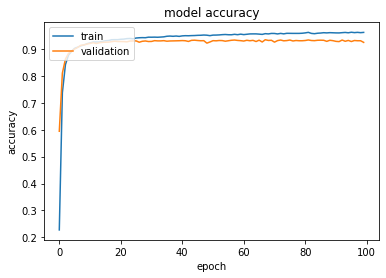

In [62]:
#Accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

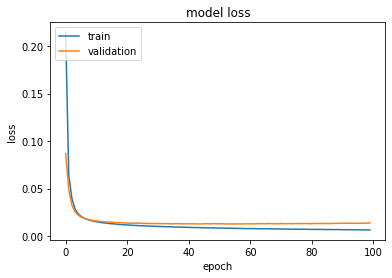

In [63]:
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

Second Technique for MLP classifier based on python library

In [64]:
from sklearn.neural_network import MLPClassifier

In [65]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.33, random_state=42,shuffle=True)

In [66]:
mlp= MLPClassifier(random_state=42,max_iter=100)

In [67]:
clf=MultiOutputClassifier(mlp,n_jobs=-1).fit(X_train,y_train)

In [68]:
y_pred=clf.predict(X_test)
y_pred

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 1, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [69]:
from sklearn.metrics import precision_score

In [70]:
precision_score(y_test,y_pred ,average='micro')

0.9337226277372263

In [71]:
precision_score(y_test,y_pred,average=None)

array([1.        , 1.        , 0.94890511, 0.91414141, 1.        ,
       0.93814433, 0.71428571, 0.79856115, 0.6744186 , 0.88135593,
       0.95108696, 0.675     , 0.92118227, 0.92473118, 0.95890411,
       0.90430622, 0.93063584, 1.        , 0.96551724, 0.99047619,
       0.98305085, 1.        , 1.        , 0.38461538, 0.8627451 ,
       0.99319728, 0.85234899, 1.        , 1.        , 1.        ,
       0.8       , 0.94545455, 1.        ])

In [72]:
clf.score(X_test,y_test)

0.9085401038661282